## Final Project Submission

Please fill out:
* Student name: Graham Wilson
* Student pace: full time
* Scheduled project review date/time: 
* Instructor name: Abhineet Kulkarni
* Blog post URL:


This project uses the Bank Marketing Dataset from UCI's archives (https://archive.ics.uci.edu/ml/datasets/bank+marketing) to find the best machine learning strategies to improve for the next marketing campaign. The goal is to provide an accurate predictive model for whether or not a potential client will or will not subscribe to a term deposit.

- Output Variable (desired target):
    - y - has the client subscribed a term deposit? (binary: "yes","no")
    
    
 - Input Variables - 
   - Continuous:
   
    - age (numeric)
    - duration: last contact duration, in seconds (numeric)
        - Important note:  this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
    - campaign: number of contacts performed during this campaign and for this client
    - pdays: number of days that passed by after the client was last contacted from a previous campaign
    - previous: number of contacts performed before this campaign and for this client
    - emp.var.rate: employment variation rate - quarterly indicator
    - cons.price.idx: consumer price index - monthly indicator     
    - cons.conf.idx: consumer confidence index - monthly indicator    
    - euribor3m: euribor 3 month rate - daily indicator
    - nr.employed: number of employees - quarterly indicator
<br>  
  
  - Categorical:
    - job : type of job
    - marital : marital status
    - education
    - default: has credit in default
    - housing: has housing loan
    - loan: has personal loan
    - contact: contact communication type 
    - month: last contact month of year 
    - day_of_week: last contact day of the week 
    - poutcome: outcome of the previous marketing campaign 

# Obtain Data

In [1]:
#Import necessary libraries and load dataset
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('bank-additional-full.csv', sep=';', index_col=False)

df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
age               41188 non-null int64
job               41188 non-null object
marital           41188 non-null object
education         41188 non-null object
default           41188 non-null object
housing           41188 non-null object
loan              41188 non-null object
contact           41188 non-null object
month             41188 non-null object
day_of_week       41188 non-null object
duration          41188 non-null int64
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
poutcome          41188 non-null object
emp.var.rate      41188 non-null float64
cons.price.idx    41188 non-null float64
cons.conf.idx     41188 non-null float64
euribor3m         41188 non-null float64
nr.employed       41188 non-null float64
y                 41188 non-null object
dtypes: float64(5), int64(5), object(11)
memory usa

The dataframe has 41188 rows and 21 columns with no missing values. The last column, 'y', is the target variable. The other 20 columns are divided evenly between continuous and categorical independent variables.

# Scrub

## Create Subsets of the data

First, create new dataframes dividing categotical from continuous variables, and splitting out the dependent variable

In [3]:
#create a dataframe for continuous variables
cont_df = df[['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
             'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']]
cont_df.head(2)

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0


In [4]:
#create a dataframe for categorical variables
cat_df = df[['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
            'month', 'day_of_week', 'poutcome']]
cat_df.head(2)

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
0,housemaid,married,basic.4y,no,no,no,telephone,may,mon,nonexistent
1,services,married,high.school,unknown,no,no,telephone,may,mon,nonexistent


In [5]:
#create a dataframe for target variable
target = df[['y']]
target.head(2)

,y
0,no
1,no


## Continuous Variable Cleaning

In [6]:
cont_df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [7]:
#explore cont df for outlier data
for col in cont_df.columns:
    print(col, '\n', cont_df[col].value_counts(normalize=True).head(), '\n\n')

age 
 31    0.047271
32    0.044819
33    0.044503
36    0.043216
35    0.042707
Name: age, dtype: float64 


duration 
 85     0.004127
90     0.004127
136    0.004079
73     0.004055
124    0.003982
Name: duration, dtype: float64 


campaign 
 1    0.428329
2    0.256628
3    0.129674
4    0.064363
5    0.038822
Name: campaign, dtype: float64 


pdays 
 999    0.963217
3      0.010658
6      0.010003
4      0.002865
9      0.001554
Name: pdays, dtype: float64 


previous 
 0    0.863431
1    0.110736
2    0.018306
3    0.005244
4    0.001700
Name: previous, dtype: float64 


emp.var.rate 
  1.4    0.394144
-1.8    0.222978
 1.1    0.188477
-0.1    0.089419
-2.9    0.040376
Name: emp.var.rate, dtype: float64 


cons.price.idx 
 93.994    0.188477
93.918    0.162305
92.893    0.140672
93.444    0.125643
94.465    0.106196
Name: cons.price.idx, dtype: float64 


cons.conf.idx 
 -36.4    0.188477
-42.7    0.162305
-46.2    0.140672
-36.1    0.125643
-41.8    0.106196
Name: cons.conf.idx,

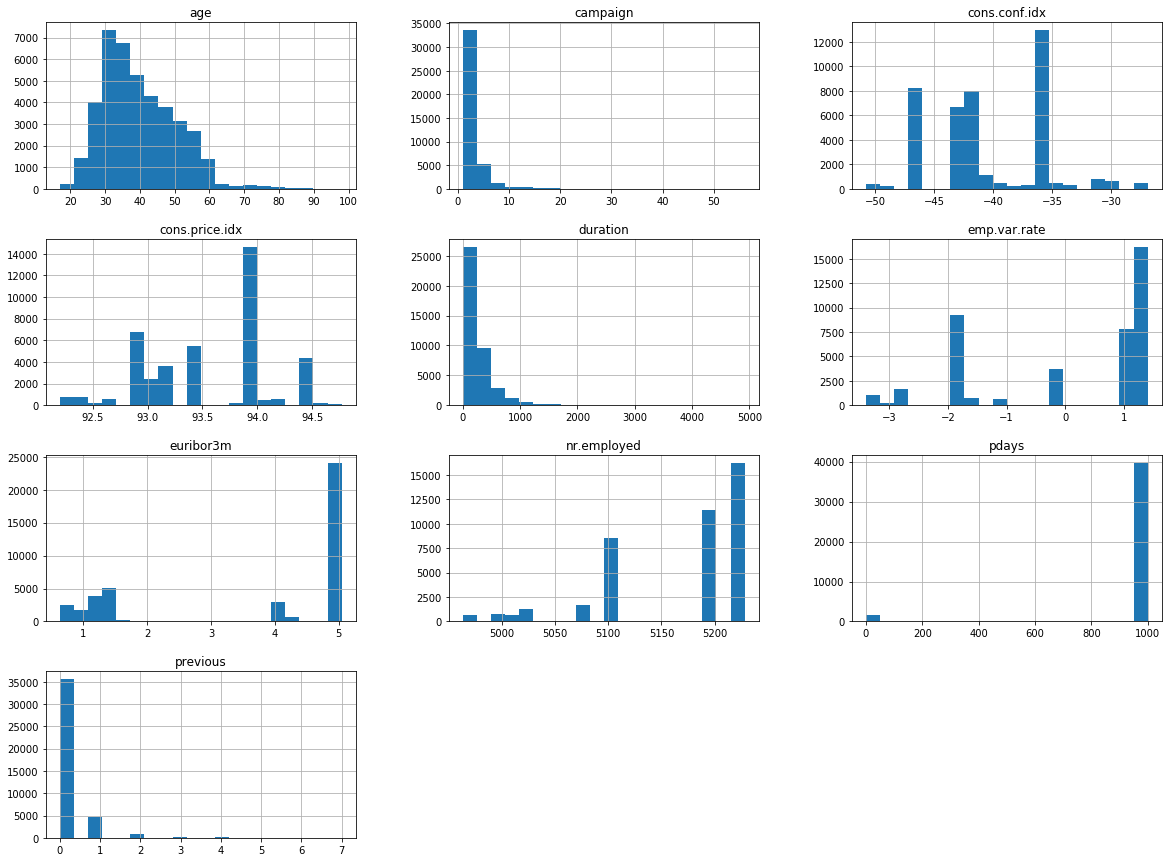

In [8]:
#visualize cont df histograms
cont_df.hist(bins=20, figsize=(20,15))
plt.show()

- It looks like 'campaign', 'duration', and 'previous' are highly skewed. So, take a look at those categories and remove or impute outliers.
<br>
<br>
- 'pdays' is the number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted). This means pdays should be a categorical variable (0,1)

### Campaign

Campaign is the number of contacts performed during this campaign and for this client

In [9]:
cont_df['campaign'].value_counts()

1     17642
2     10570
3      5341
4      2651
5      1599
6       979
7       629
8       400
9       283
10      225
11      177
12      125
13       92
14       69
17       58
15       51
16       51
18       33
20       30
19       26
21       24
22       17
23       16
24       15
27       11
29       10
25        8
26        8
28        8
30        7
31        7
35        5
33        4
32        4
34        3
40        2
42        2
43        2
37        1
39        1
41        1
56        1
Name: campaign, dtype: int64

In [10]:
# Determine outlier data points
len(cont_df[cont_df['campaign'] > 32]) / len(cont_df) * 100

0.05341361561619889

In [11]:
#replace outlier values with median values to address skewness
median = float(cont_df['campaign'].median())
cont_df['campaign'] = np.where(cont_df['campaign'] > 32, median,cont_df['campaign'])

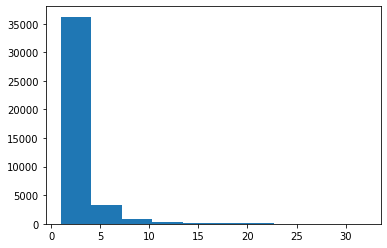

In [12]:
plt.hist(cont_df['campaign'])
plt.show()

- This didn't seem to help with skewness, so it will be addressed during normalization after the train test split.

### Duration

Last contact duration, in seconds. 
<br>
<br>
Important note:  this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

Due to collinearity, it may be best to drop this column from the dataset. This can be addressed at a later time.


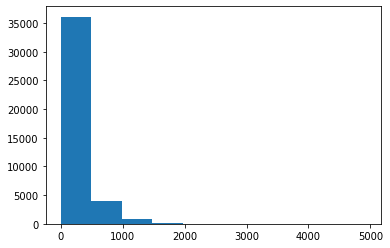

In [13]:
plt.hist(cont_df['duration'])
plt.show()

In [14]:
len(cont_df[cont_df['duration'] > 2500]) / len(cont_df) * 100

0.05826939885403516

In [15]:
median = float(cont_df['duration'].median())
cont_df['duration'] = np.where(cont_df['duration'] > 2500, median,cont_df['duration'])

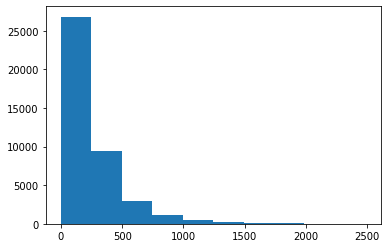

In [16]:
plt.hist(cont_df['duration'])
plt.show()

- Again not much has been changed, will address later.

### Previous

Number of contacts performed before this campaign and for this client

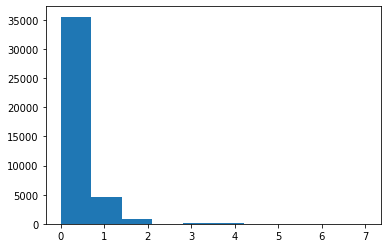

In [17]:
plt.hist(cont_df['previous'])
plt.show()

In [18]:
len(cont_df[cont_df['previous'] > 4]) / len(cont_df) * 100

0.05826939885403516

In [19]:
median = float(cont_df['previous'].median())
cont_df['previous'] = np.where(cont_df['previous'] > 4, median,cont_df['previous'])

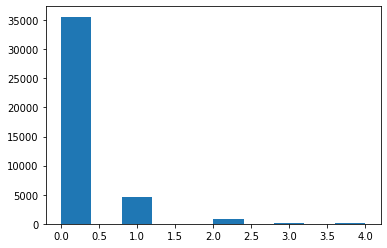

In [20]:
plt.hist(cont_df['previous'])
plt.show()

### Pdays

Number of days that passed by after the client was last contacted from a previous campaign (999 means client was not previously contacted)

Since clients were either contacted or not, this variable should be converted into boolean values and treated as a categorical variable.

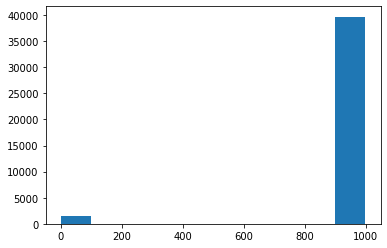

In [21]:
plt.hist(cont_df['pdays'])
plt.show()

In [22]:
cont_df['pdays'].value_counts(normalize=True)

999    0.963217
3      0.010658
6      0.010003
4      0.002865
9      0.001554
2      0.001481
7      0.001457
12     0.001408
10     0.001263
5      0.001117
13     0.000874
11     0.000680
1      0.000631
15     0.000583
14     0.000486
8      0.000437
0      0.000364
16     0.000267
17     0.000194
18     0.000170
19     0.000073
22     0.000073
21     0.000049
26     0.000024
20     0.000024
25     0.000024
27     0.000024
Name: pdays, dtype: float64

- Instead of creating a categorical variable, it may be best just to change the 999 values to 0 and keep the data as contiuous

In [23]:
#replace 999 values with 0
cont_df['pdays'] = cont_df['pdays'].replace(to_replace=999, value=0)

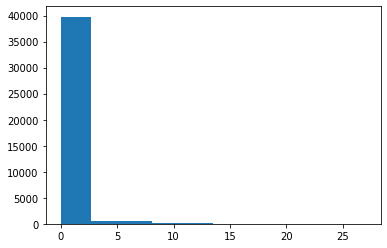

In [24]:
plt.hist(cont_df['pdays'])
plt.show()

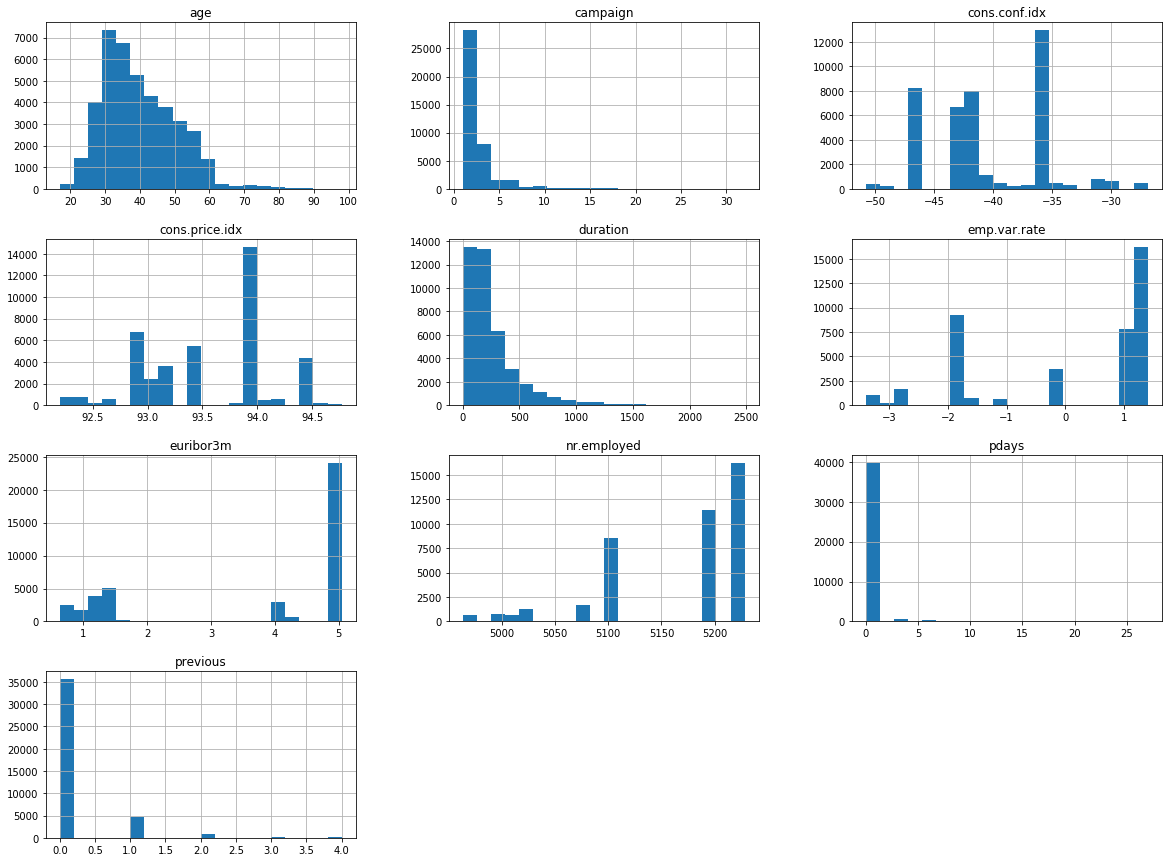

In [25]:
cont_df.hist(bins=20, figsize=(20,15))
plt.show()

- The initial cleaning of outliers should help with model prediction, normalization must be done later to address scaling and skewdness

## Categorical Cleaning

In [26]:
cat_df.head()

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
0,housemaid,married,basic.4y,no,no,no,telephone,may,mon,nonexistent
1,services,married,high.school,unknown,no,no,telephone,may,mon,nonexistent
2,services,married,high.school,no,yes,no,telephone,may,mon,nonexistent
3,admin.,married,basic.6y,no,no,no,telephone,may,mon,nonexistent
4,services,married,high.school,no,no,yes,telephone,may,mon,nonexistent


In [27]:
#Create dummy variables for categorical data
pd.set_option('display.max_columns', None)
dummy_cat_df = pd.get_dummies(cat_df, drop_first=True)
dummy_cat_df.head()

,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,marital_unknown,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_unknown,default_yes,housing_unknown,housing_yes,loan_unknown,loan_yes,contact_telephone,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
2,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
4,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0


In [28]:
dummy_cat_df.shape

(41188, 43)

### Target Variable

In [29]:
target.head()

,y
0,no
1,no
2,no
3,no
4,no


In [30]:
target['y'].value_counts(normalize=True)

no     0.887346
yes    0.112654
Name: y, dtype: float64

In [31]:
#replace yes with a value of 1
target.loc[target['y'] == 'yes', 'y'] = 1

In [32]:
target['y'].unique()

array(['no', 1], dtype=object)

In [33]:
#replace no with a value of 0
target.loc[target['y'] == 'no', 'y'] = 0

In [34]:
target['y'].value_counts(normalize=True)

0    0.887346
1    0.112654
Name: y, dtype: float64

- The target values are skewed highly in the 'no' direction, so class imbalace should be performed during the modeling process

In [35]:
target.head()

,y
0,0
1,0
2,0
3,0
4,0


# Data Exploration

## Continuous Variable multicollinearity

In [139]:
#plot a correlation matrix
corr = cont_df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,age,duration,campaign,pdays,previous,cons.price.idx,cons.conf.idx,euribor3m
age,1,0.00035,0.0043,0.018,0.023,0.00086,0.13,0.011
duration,0.00035,1,-0.071,0.05,0.023,0.0033,-0.0083,-0.036
campaign,0.0043,-0.071,1,-0.043,-0.081,0.13,-0.014,0.14
pdays,0.018,0.05,-0.043,1,0.49,-0.042,0.064,-0.25
previous,0.023,0.023,-0.081,0.49,1,-0.22,-0.05,-0.46
cons.price.idx,0.00086,0.0033,0.13,-0.042,-0.22,1,0.059,0.69
cons.conf.idx,0.13,-0.0083,-0.014,0.064,-0.05,0.059,1,0.28
euribor3m,0.011,-0.036,0.14,-0.25,-0.46,0.69,0.28,1


correlative variables above 0.8:
- nr.employed, number of employees - quarterly indicator
- emp.var.rate, euribor 3 month rate - daily indicator
- euribor3m, employment variation rate - quarterly indicator
<br>

These three features are highly correlative. Two should be dropped from the dataset to avoid multicollinearity.

In [37]:
#drop two of the variables with high collinearity
cont_df.drop(['nr.employed', 'emp.var.rate'], axis=1, inplace=True)

## Categorical Variable multicollinearity

In [140]:
corr = dummy_cat_df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

- housing_unknown, and loan_unknown have a 1 to 1 correlation, so one should be dropped from the dataset

In [39]:
#drop single category with high correlation
dummy_cat_df.drop('loan_unknown', axis=1, inplace=True)

## Merge cleaned dataframes

In [40]:
cleaned_df = pd.concat([cont_df, dummy_cat_df, target], axis=1)
cleaned_df.head()

,age,duration,campaign,pdays,previous,cons.price.idx,cons.conf.idx,euribor3m,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,marital_unknown,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_unknown,default_yes,housing_unknown,housing_yes,loan_yes,contact_telephone,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success,y
0,56,261.0,1.0,0,0.0,93.994,-36.4,4.857,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0
1,57,149.0,1.0,0,0.0,93.994,-36.4,4.857,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0
2,37,226.0,1.0,0,0.0,93.994,-36.4,4.857,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0
3,40,151.0,1.0,0,0.0,93.994,-36.4,4.857,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0
4,56,307.0,1.0,0,0.0,93.994,-36.4,4.857,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0


# Model

## Logistic Regression

### Train Test Split

In [41]:
#split predictor and target variables
X = cleaned_df.drop('y', axis = 1)
y = cleaned_df['y']

In [42]:
#Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [43]:
#scale data
scaler = StandardScaler()

scaled_train = scaler.fit_transform(X_train)
scaled_test = scaler.transform(X_test)

scaled_train_df = pd.DataFrame(scaled_train, columns = X.columns)
scaled_train_df.head()

,age,duration,campaign,pdays,previous,cons.price.idx,cons.conf.idx,euribor3m,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,marital_unknown,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_unknown,default_yes,housing_unknown,housing_yes,loan_yes,contact_telephone,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
0,-0.678576,-0.775846,0.558563,-0.16349,-0.354793,-0.227761,0.955732,0.774165,-0.536591,-0.192156,-0.160948,-0.276232,-0.210021,-0.191793,-0.327784,-0.146723,-0.444892,-0.157851,-0.088302,-1.235081,1.599135,-0.042233,-0.243718,-0.411050,-0.545940,-0.020519,-0.384127,1.542767,-0.212362,-0.514619,-0.009855,-0.156879,-1.046362,-0.419089,-0.756929,2.388867,-0.066252,-0.458452,-0.385901,-0.114391,-0.709890,-0.334405,-0.131615,-0.119372,-0.509583,-0.512907,-0.493101,1.999636,0.398865,-0.186282
1,-1.158329,-0.739538,-0.584578,-0.16349,-0.354793,0.722845,0.890783,0.714143,-0.536591,5.204107,-0.160948,-0.276232,-0.210021,-0.191793,-0.327784,-0.146723,-0.444892,-0.157851,-0.088302,0.809663,-0.625338,-0.042233,-0.243718,2.432792,-0.545940,-0.020519,-0.384127,-0.648186,-0.212362,1.943187,-0.009855,-0.156879,-1.046362,-0.419089,1.321128,-0.418608,-0.066252,-0.458452,-0.385901,-0.114391,1.408669,-0.334405,-0.131615,-0.119372,-0.509583,1.949670,-0.493101,-0.500091,0.398865,-0.186282
2,1.240439,-0.687093,0.939610,-0.16349,-0.354793,0.722845,0.890783,0.716452,-0.536591,-0.192156,-0.160948,-0.276232,-0.210021,-0.191793,3.050788,-0.146723,-0.444892,-0.157851,-0.088302,0.809663,-0.625338,-0.042233,-0.243718,-0.411050,-0.545940,-0.020519,-0.384127,-0.648186,-0.212362,-0.514619,-0.009855,-0.156879,-1.046362,-0.419089,1.321128,-0.418608,-0.066252,-0.458452,-0.385901,-0.114391,1.408669,-0.334405,-0.131615,-0.119372,-0.509583,-0.512907,-0.493101,-0.500091,0.398865,-0.186282
3,-0.006920,1.079889,0.177516,-0.16349,1.720553,-1.978604,2.947498,-1.672880,-0.536591,-0.192156,-0.160948,-0.276232,-0.210021,-0.191793,-0.327784,-0.146723,-0.444892,-0.157851,-0.088302,0.809663,-0.625338,-0.042233,-0.243718,-0.411050,1.831704,-0.020519,-0.384127,-0.648186,-0.212362,-0.514619,-0.009855,-0.156879,-1.046362,-0.419089,-0.756929,-0.418608,-0.066252,-0.458452,-0.385901,-0.114391,-0.709890,-0.334405,7.597903,-0.119372,-0.509583,-0.512907,-0.493101,1.999636,-2.507113,-0.186282
4,-0.966428,0.640160,-0.584578,-0.16349,-0.354793,-0.649484,-0.321596,0.328041,-0.536591,-0.192156,-0.160948,-0.276232,-0.210021,-0.191793,3.050788,-0.146723,-0.444892,-0.157851,-0.088302,0.809663,-0.625338,-0.042233,-0.243718,2.432792,-0.545940,-0.020519,-0.384127,-0.648186,-0.212362,1.943187,-0.009855,-0.156879,-1.046362,-0.419089,-0.756929,-0.418608,-0.066252,-0.458452,-0.385901,-0.114391,-0.709890,2.990383,-0.131615,-0.119372,1.962390,-0.512907,-0.493101,-0.500091,0.398865,-0.186282


### Model

- Build a model proior to addressing class imbalance for the target variable

In [44]:
#Import necessary module and build model
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')
model_log = logreg.fit(scaled_train, y_train)
model_log

LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [45]:
#Model predictions for test and train sets
y_hat_train = logreg.predict(scaled_train)
y_hat_test = logreg.predict(scaled_test)

In [46]:
residuals = np.abs(y_train - y_hat_train)
print(pd.Series(residuals).value_counts(normalize=True))

0    0.81247
1    0.18753
Name: y, dtype: float64


In [47]:
residuals = np.abs(y_test - y_hat_test)
print(pd.Series(residuals).value_counts(normalize=True))

0    0.812081
1    0.187919
Name: y, dtype: float64


In [48]:
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.99      0.80      0.88      9119
           1       0.37      0.93      0.53      1178

    accuracy                           0.81     10297
   macro avg       0.68      0.86      0.71     10297
weighted avg       0.92      0.81      0.84     10297



### Visualizations

AUC: 0.8632245757891646


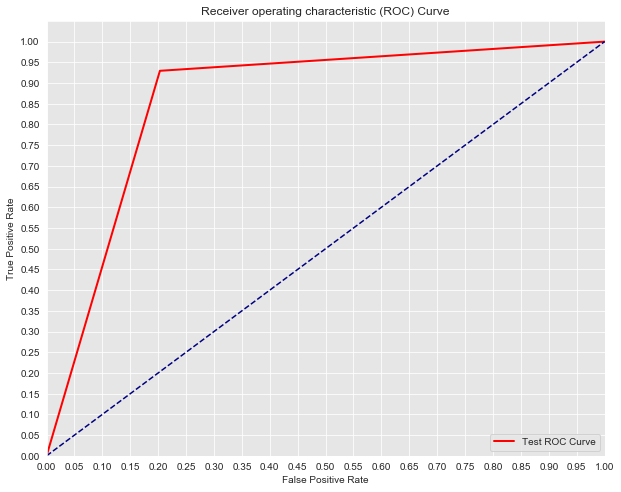

In [49]:
# Plot ROC and determine AUC
from sklearn.metrics import roc_auc_score, roc_curve, auc

test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_hat_test)

print('AUC: {}'.format(auc(test_fpr, test_tpr)))

sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

plt.figure(figsize=(10, 8))
lw=2

plt.plot(test_fpr, test_tpr, color='red', lw=lw, label='Test ROC Curve')

plt.plot([0, 1], [0, 1], color = 'navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [50]:
#print confusion matrix
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix:\n', cnf_matrix)

Confusion Matrix:
 [[7267 1852]
 [  83 1095]]


 - The baseline model has 80% predictive accuracy with an AUC score of 0.86. It has a precicion of 0.99, recall of 0.79, and F1 score of 0.88. The yes/no ration of predictive values are skewed toward no, so this can be addressed using SMOTE to see if any of these values can be increase.


### Address class imbalance with smote

In [51]:
#import necessary module
from imblearn.over_sampling import SMOTE

In [52]:
# Previous original class distribution
print('Original class distribution: \n')
print(y.value_counts())

#resample data
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_sample(scaled_train, y_train)

# Preview synthetic sample class distribution
print('-----------------------------------------')
print('Synthetic sample class distribution: \n')
print(pd.Series(y_train_resampled).value_counts()) 

Original class distribution: 

0    36548
1     4640
Name: y, dtype: int64
-----------------------------------------
Synthetic sample class distribution: 

1    27429
0    27429
Name: y, dtype: int64


In [53]:
#fit model using resampled data
logreg = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')
model_log = logreg.fit(X_train_resampled, y_train_resampled)
model_log

LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [54]:
#Predict
y_hat_train = logreg.predict(X_train_resampled)
y_hat_test = logreg.predict(scaled_test)

In [55]:
#Training predictions
residuals = np.abs(y_train_resampled - y_hat_train)
print(pd.Series(residuals).value_counts(normalize=True))

0    0.855955
1    0.144045
Name: y, dtype: float64


In [56]:
#Test predictions
residuals = np.abs(y_test - y_hat_test)
print(pd.Series(residuals).value_counts(normalize=True))

0    0.750995
1    0.249005
Name: y, dtype: float64


In [57]:
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       1.00      0.72      0.84      9119
           1       0.31      0.97      0.47      1178

    accuracy                           0.75     10297
   macro avg       0.65      0.85      0.65     10297
weighted avg       0.92      0.75      0.80     10297



In [58]:
#print confusion matrix
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix:\n', cnf_matrix)

Confusion Matrix:
 [[6585 2534]
 [  30 1148]]


- The precision increased using smote. However, recall, F1, and accuracy of the model decreased using this method.
- Check to see if adding in various ratios to the majority/minority classes have a positive affect on the model using smote

#### Visualizations

LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for 0.25: 0.9279068256337493
-------------------------------------------------------------------------------------
LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for 0.33: 0.928943858891983
-------------------------------------------------------------------------------------
LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
        

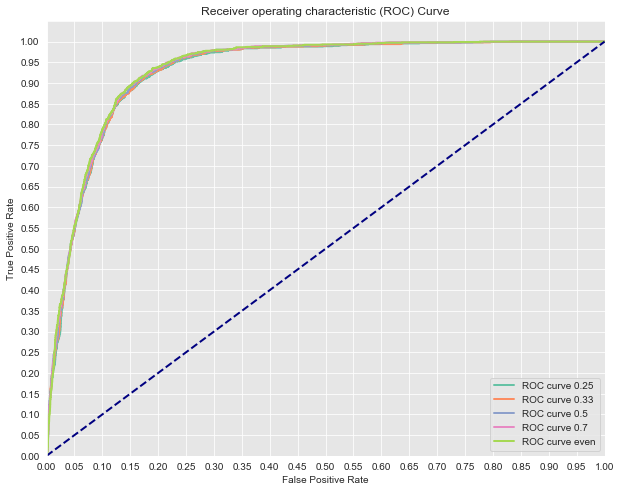

In [59]:
#compare a few different ratios of minority class to majority class


ratios = [0.25, 0.33, 0.5, 0.7, 1]
names = ['0.25', '0.33','0.5','0.7','even']
colors = sns.color_palette('Set2')

plt.figure(figsize=(10, 8))

#create a for loop to fit various ratios
for n, ratio in enumerate(ratios):

    smote = SMOTE(sampling_strategy=ratio)
    X_train_resampled, y_train_resampled = smote.fit_sample(scaled_train, y_train) 
    logreg = LogisticRegression(fit_intercept=False, C=1e12, solver ='liblinear')
    model_log = logreg.fit(X_train_resampled, y_train_resampled)
    print(model_log)

    # Predict
    y_hat_test = logreg.predict(scaled_test)

    y_score = logreg.decision_function(scaled_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    print('-------------------------------------------------------------------------------------')
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve {}'.format(names[n]))

#plot results    
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

 - The SMOTE ratio doesn't to have much of an affect on the linear regression model. The unweighted model appears to be the top performer by a very small margin.
 - Overall, is seems as though SMOTE had a negative affect on the logistic regression model


# Regular baseline tree

In [60]:
X = cleaned_df.drop('y', axis = 1)
y = cleaned_df['y']

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [62]:
#scale data
scaler = StandardScaler()

scaled_train = scaler.fit_transform(X_train)
scaled_test = scaler.transform(X_test)

scaled_train_df = pd.DataFrame(scaled_train, columns = X.columns)
scaled_train_df.head()

,age,duration,campaign,pdays,previous,cons.price.idx,cons.conf.idx,euribor3m,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,marital_unknown,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_unknown,default_yes,housing_unknown,housing_yes,loan_yes,contact_telephone,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
0,0.576454,-0.783526,1.675269,-0.164240,-0.352708,0.591648,-0.474408,0.772635,-0.536291,-0.191157,-0.161792,-0.277113,-0.209769,-0.189422,-0.326511,-0.147756,-0.44118,-0.157959,-0.09302,-1.237927,1.595173,-0.042995,-0.243942,-0.414649,-0.547788,-0.022041,-0.382516,1.544206,-0.210021,-0.515373,-0.00569,-0.155902,0.948463,2.375848,-0.759524,-0.419676,-0.068674,2.190402,-0.383683,-0.114682,-0.710818,-0.334764,-0.130593,-0.119372,-0.509633,-0.514719,2.020295,-0.495484,0.395205,-0.18432
1,0.959619,-0.954128,6.197286,-0.164240,-0.352708,0.723120,0.889349,0.712636,-0.536291,-0.191157,-0.161792,-0.277113,-0.209769,-0.189422,-0.326511,-0.147756,-0.44118,-0.157959,-0.09302,0.807802,-0.626891,-0.042995,-0.243942,-0.414649,1.825524,-0.022041,-0.382516,-0.647582,-0.210021,-0.515373,-0.00569,-0.155902,0.948463,-0.420902,1.316615,-0.419676,-0.068674,-0.456537,-0.383683,-0.114682,1.406829,-0.334764,-0.130593,-0.119372,-0.509633,-0.514719,2.020295,-0.495484,0.395205,-0.18432
2,2.971238,-0.377330,-0.208905,-0.164240,-0.352708,-0.866652,-1.426873,-1.273094,-0.536291,-0.191157,-0.161792,-0.277113,4.767159,-0.189422,-0.326511,-0.147756,-0.44118,-0.157959,-0.09302,0.807802,-0.626891,-0.042995,-0.243942,-0.414649,1.825524,-0.022041,-0.382516,-0.647582,-0.210021,-0.515373,-0.00569,-0.155902,0.948463,-0.420902,-0.759524,-0.419676,-0.068674,-0.456537,-0.383683,-0.114682,-0.710818,-0.334764,-0.130593,-0.119372,-0.509633,-0.514719,-0.494977,2.018229,0.395205,-0.18432
3,0.768037,-0.937881,1.675269,-0.164240,1.739362,-1.181493,-1.232051,-1.359054,-0.536291,-0.191157,-0.161792,-0.277113,-0.209769,-0.189422,3.062685,-0.147756,-0.44118,-0.157959,-0.09302,-1.237927,1.595173,-0.042995,-0.243942,-0.414649,-0.547788,-0.022041,-0.382516,-0.647582,-0.210021,1.940341,-0.00569,-0.155902,0.948463,-0.420902,-0.759524,-0.419676,-0.068674,-0.456537,-0.383683,-0.114682,1.406829,-0.334764,-0.130593,-0.119372,-0.509633,1.942807,-0.494977,-0.495484,-2.530334,-0.18432
4,-1.147791,-0.657605,0.167929,8.051433,3.831431,-0.866652,-1.426873,-1.251172,-0.536291,-0.191157,-0.161792,-0.277113,-0.209769,-0.189422,-0.326511,6.767906,-0.44118,-0.157959,-0.09302,-1.237927,1.595173,-0.042995,-0.243942,-0.414649,-0.547788,-0.022041,-0.382516,1.544206,-0.210021,-0.515373,-0.00569,-0.155902,0.948463,-0.420902,-0.759524,-0.419676,-0.068674,-0.456537,-0.383683,-0.114682,-0.710818,-0.334764,-0.130593,-0.119372,-0.509633,-0.514719,2.020295,-0.495484,-2.530334,-0.18432


In [63]:
# Build a baseline tree
tree_clf = DecisionTreeClassifier(criterion='gini', max_depth=5)
tree_clf.fit(scaled_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

### Feature Importance

In [64]:
tree_clf.feature_importances_

array([0.00141572, 0.51075695, 0.00080706, 0.        , 0.        ,
       0.03611826, 0.02994339, 0.36835055, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00208422,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00204764, 0.        , 0.01079761, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.03767858])

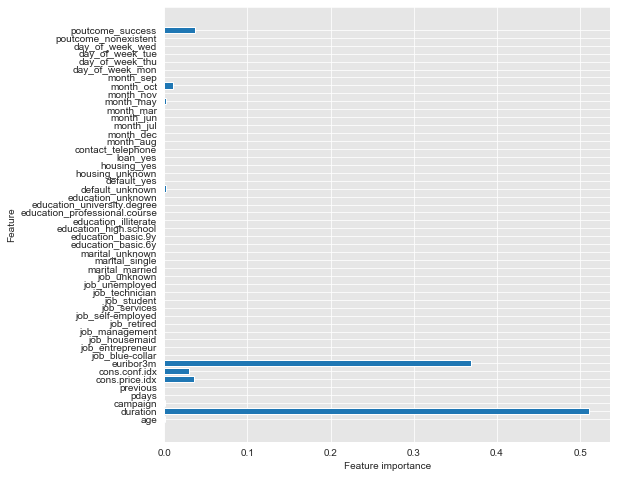

In [65]:
#plot feature importance

def plot_feature_importances(model):
    n_features = scaled_train_df.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), scaled_train_df.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(tree_clf)

In [66]:
# Test set predictions
pred = tree_clf.predict(scaled_test)

# Confusion matrix and classification report
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[8689  398]
 [ 528  682]]
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      9087
           1       0.63      0.56      0.60      1210

    accuracy                           0.91     10297
   macro avg       0.79      0.76      0.77     10297
weighted avg       0.91      0.91      0.91     10297



In [67]:
print("Testing Accuracy for Decision Tree Classifier: {:.4}%".format(accuracy_score(y_test, pred) * 100))

Testing Accuracy for Decision Tree Classifier: 91.01%


 - Duration seems to be the most important feature. However, the variable description mentions that this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
 - It may be best to drop this variable and run the model again.

### Drop Duration and rerun model

In [68]:
X_2 = cleaned_df.drop(columns =['y', 'duration'], axis = 1)
y = cleaned_df['y']

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X_2, y, test_size=0.25)

scaler = StandardScaler()

scaled_train = scaler.fit_transform(X_train)
scaled_test = scaler.transform(X_test)

scaled_train_df = pd.DataFrame(scaled_train, columns = X_2.columns)

tree_clf = DecisionTreeClassifier(criterion='gini', max_depth=5)
tree_clf.fit(scaled_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

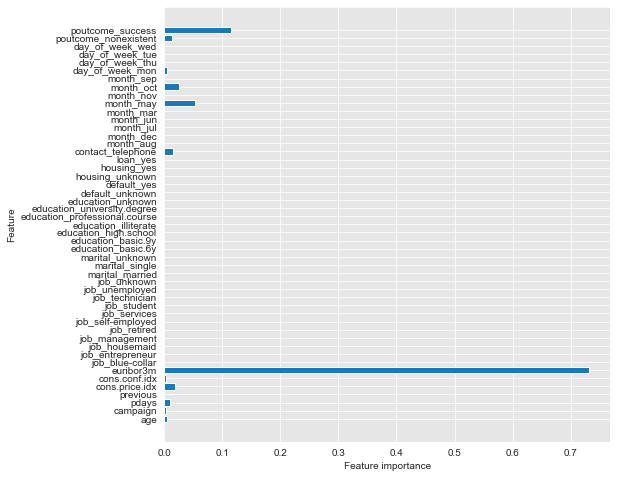

In [70]:
def plot_feature_importances(model):
    n_features = scaled_train_df.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), scaled_train_df.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(tree_clf)

In [71]:
# Test set predictions
pred = tree_clf.predict(scaled_test)

# Confusion matrix and classification report
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[8966  150]
 [ 870  311]]
              precision    recall  f1-score   support

           0       0.91      0.98      0.95      9116
           1       0.67      0.26      0.38      1181

    accuracy                           0.90     10297
   macro avg       0.79      0.62      0.66     10297
weighted avg       0.88      0.90      0.88     10297



In [72]:
print("Testing Accuracy for Decision Tree Classifier: {:.4}%".format(accuracy_score(y_test, pred) * 100))

Testing Accuracy for Decision Tree Classifier: 90.09%


In [73]:
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix:\n', cnf_matrix)

Confusion Matrix:
 [[5835 3281]
 [ 775  406]]


- Both precision and accuracy decreased by 0.03 and 0.01, respectively, while recall increased by 0.03

## Random Forest

In [ ]:
#Build random forest model
forest = RandomForestClassifier(n_estimators=100, max_depth= 5, max_features = 15)
forest.fit(scaled_train, y_train)

In [75]:
forest.score(scaled_train, y_train)

0.9012981127189149

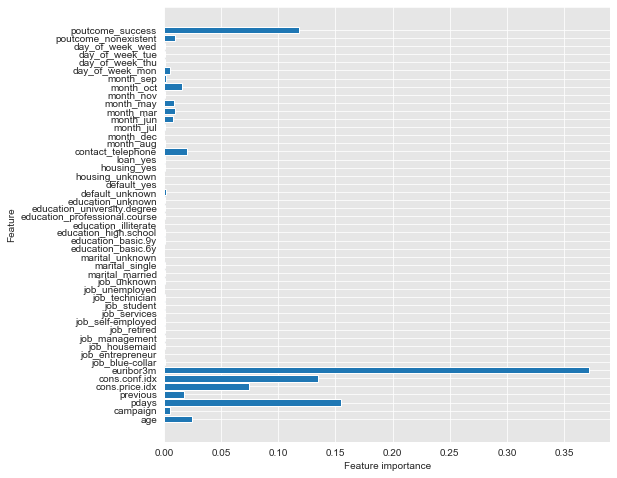

In [76]:
plot_feature_importances(forest)

- The important features changed quite a bit between a single tree vs a random forest.

In [81]:
# Test set predictions
pred = forest.predict(scaled_test)

# Confusion matrix and classification report
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[8993  123]
 [ 924  257]]
              precision    recall  f1-score   support

           0       0.91      0.99      0.94      9116
           1       0.68      0.22      0.33      1181

    accuracy                           0.90     10297
   macro avg       0.79      0.60      0.64     10297
weighted avg       0.88      0.90      0.87     10297



### Grid Search

In [83]:
rf_clf = RandomForestClassifier()

rf_param_grid = {
    'n_estimators': [10, 30, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 6, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [3, 6]
}

rf_grid_search = GridSearchCV(rf_clf, rf_param_grid, cv=5, return_train_score=True)
rf_grid_search.fit(scaled_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [84]:
print(f"Optimal Parameters: {rf_grid_search.best_params_}")

Optimal Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 6, 'min_samples_split': 10, 'n_estimators': 30}


#### Rerun RF with bestfit parameters

In [87]:
# Test set predictions
rf_best_clf = RandomForestClassifier(criterion = 'gini', max_depth= None, min_samples_leaf = 6,
                          min_samples_split = 10, n_estimators = 30)

rf_best_clf.fit(scaled_train, y_train)
pred = rf_best_clf.predict(scaled_test)

# Confusion matrix and classification report
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[8976  140]
 [ 873  308]]
              precision    recall  f1-score   support

           0       0.91      0.98      0.95      9116
           1       0.69      0.26      0.38      1181

    accuracy                           0.90     10297
   macro avg       0.80      0.62      0.66     10297
weighted avg       0.89      0.90      0.88     10297



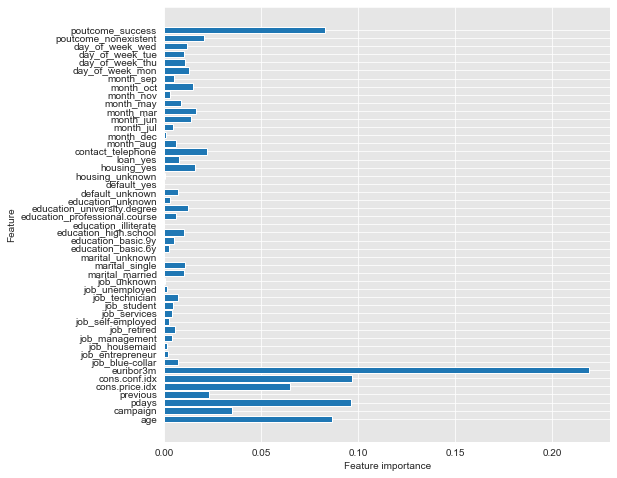

In [100]:
plot_feature_importances(rf_best_clf)

- Not much changed using grid search on the random forest model. There eas a percent decrease in recall, and a percent increasein F1, and the top 3 important features changed. Both had model accuracies of 90%.

## XG Boost

In [88]:
#import xgboost as xgb

#clf = xgb.XGBClassifier()
#clf.fit(scaled_train, y_train)
#training_preds = clf.predict(scaled_train)
#val_preds = clf.predict(scaled_test)
#training_accuracy = accuracy_score(y_train, training_preds)
#val_accuracy = accuracy_score(y_test, val_preds)

#print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
#print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

Training Accuracy: 90.33%
Validation accuracy: 90.11%


In [95]:
#param_grid = {
#    'learning_rate': [0.1, 0.3, 0.5],
#    'max_depth': [None, 3, 5, 15],
#    'min_child_weight': [5, 10],
#    'subsample': [0.5, 0.7, 0.9],
#    'n_estimators': [5, 30, 100, 250],
#}

In [96]:
#grid_clf = GridSearchCV(clf, param_grid, scoring='accuracy', cv=None, n_jobs=1)
#grid_clf.fit(scaled_train, y_train)

#best_parameters = grid_clf.best_params_

#print("Grid Search found the following optimal parameters: ")
#for param_name in sorted(best_parameters.keys()):
#    print("%s: %r" % (param_name, best_parameters[param_name]))

#training_preds = grid_clf.predict(scaled_train)
#val_preds = grid_clf.predict(scaled_test)
#training_accuracy = accuracy_score(y_train, training_preds)
#val_accuracy = accuracy_score(y_test, val_preds)

#print("")
#print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
#print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

Grid Search found the following optimal parameters: 
learning_rate: 0.1
max_depth: 5
min_child_weight: 5
n_estimators: 5
subsample: 0.7

Training Accuracy: 90.26%
Validation accuracy: 90.21%


### Run Model with optimal parameters

In [ ]:
##Best parameters
#param_grid = {
#    'learning_rate': [0.1],
#    'max_depth': [5],
#    'min_child_weight': [5],
#    'subsample': [0.7],
#    'n_estimators': [5],
#}

In [97]:
# Test set predictions
xg_best = xgb.XGBClassifier(learning_rate = 0.1, max_depth=5, min_child_weight = 5, 
                           subsample = 0.7, n_estimators = 5)

xg_best.fit(scaled_train, y_train)
pred = xg_best.predict(scaled_test)

# Confusion matrix and classification report
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[8952  164]
 [ 844  337]]
              precision    recall  f1-score   support

           0       0.91      0.98      0.95      9116
           1       0.67      0.29      0.40      1181

    accuracy                           0.90     10297
   macro avg       0.79      0.63      0.67     10297
weighted avg       0.89      0.90      0.88     10297



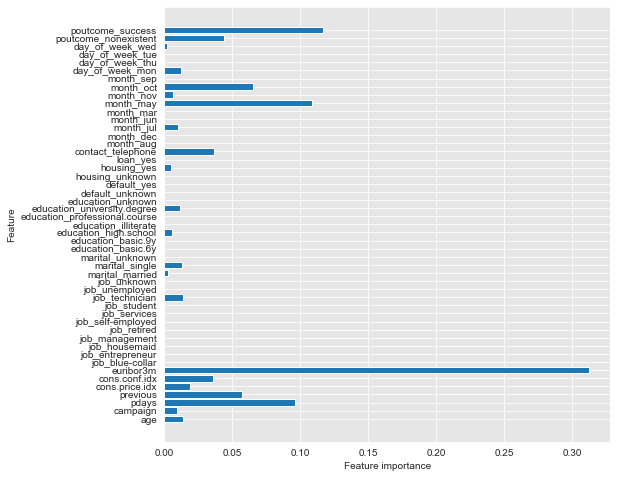

In [98]:
plot_feature_importances(xg_best)

# Interpret

## euribor3m

- The most important feature in most models is the 'euribor3m'. This is the 3 month Euribor interest rate at which a selection of European banks lend one another funds denominated in euros whereby the loans have a maturity of 3 months. The Euribor interest rates are the most important European interbank interest rates.

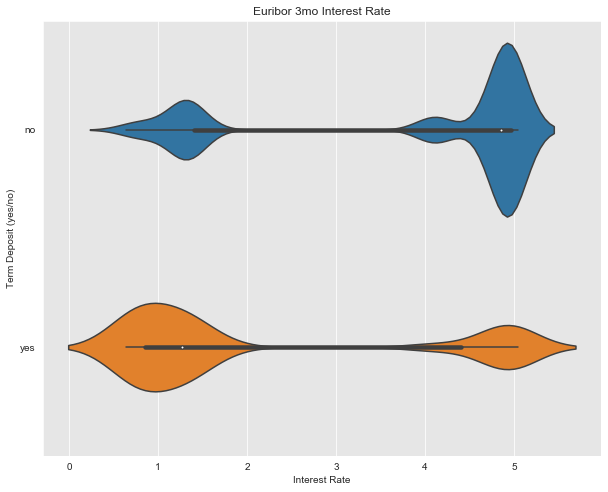

In [108]:
plt.figure(figsize=(10, 8))
sns.violinplot(x='euribor3m', y = 'y', data=df)

plt.title("Euribor 3mo Interest Rate")
plt.xlabel("Interest Rate")
plt.ylabel("Term Deposit (yes/no)")
plt.show()

- The violin plot clearly shows that most clients subscribe to a term deposit when interest rates are low, whereas the opposite is true when interest rates are high. This seems counter intuitive as most investors would perfer a higher return on investment for their deposits. It may be an issue where banks are less likely to approve/provide investors with higher yield term deposits as the intitutions would have to pay more to each investor over the term limit.

## poutcome

- poutcome is the outcome of the previous marketing campaign. The dummy variable poutcome_success was the second most important feature to most of the models run.

In [114]:
df_target = pd.concat([df, target], axis=1)
df_target.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0


In [115]:
df_target['y'].head()

,y,y
0,no,0
1,no,0
2,no,0
3,no,0
4,no,0


In [116]:
df_target = df_target.drop(df_target.columns[-2], axis=1)
df_target.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0


In [117]:
df_target = pd.concat([df_target, target], axis=1)
df_target.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


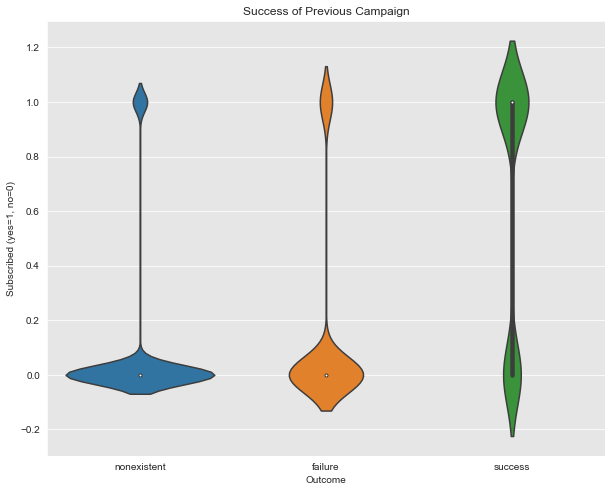

In [136]:
plt.figure(figsize=(10, 8))
sns.violinplot(x='poutcome', y = 'y', data=df_target)

plt.title("Success of Previous Campaign")
plt.xlabel("Outcome")
plt.ylabel("Subscribed (yes=1, no=0)")
plt.show()

- The violin plot shows that banks are more successful in currently marketing to those who have previously signed up for term deposits in the past.

## Month

- Month is described as the last contact month of year. 

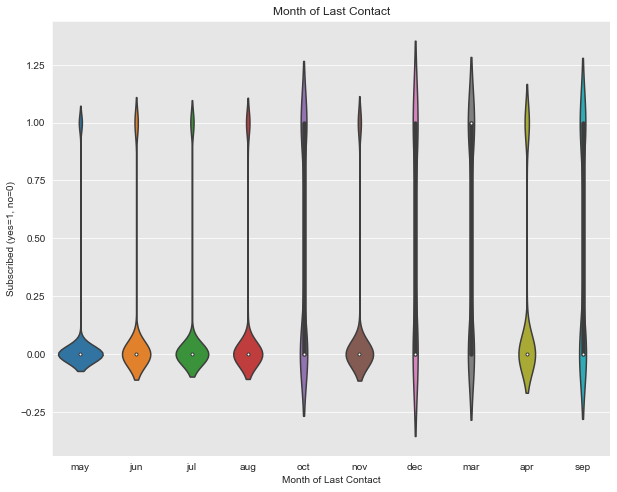

In [138]:
plt.figure(figsize=(10, 8))
sns.violinplot(x='month', y='y', data=df_target)

plt.title("Month of Last Contact")
plt.xlabel("Month of Last Contact")
plt.ylabel("Subscribed (yes=1, no=0)")
plt.show()

- This plot shows that if potential clients last contact was during the summer months (May-Aug) they're less likely to subscribe to a term deposit. The most influential month being May, where there is the highest density of nonsubscribers.

# Conclusion

Overall, each model performed relatively well. The worst performing model is logistic regression using smote for class imbalance. The worst performing model had a precision of 1, recall of 0.72, F1 score of 0.84, and an accuracy of 0.75. The remaining models (decision tree, random forest, and xg boost) all performed similarly. Precision ranged between (0.91-0.94), recall (0.96-0.98), F1 (0.94-0.95), accuracy (0.90).

Of all the variables, euribor3m was the most important feature for each model once duration was removed. Other noteable variables include poutcome_success, month_may, pdays, and cons.conf.idx. 

After investigating 3 of the top most important features, it's recommended that banks focus in on contacting previous subscribers closer to the end of the calendar year especially while interest rates are low.